# Estimation non-paramétrique univariée

**Objectif**
- modéliser les fonctions de survie et de risque avec Kaplan-Meier & Nelson-Aalen
- étudier l'impact de la censure sur les estimateurs
- étudier l'impact d'une vidéo promotionnelle sur les estimateurs


## Import des outils / jeu de données

In [ ]:
import pandas as pd

from src.modelisation.univariate.non_parametric.models import (
    create_hazard_models,
    create_survival_models,
)
from src.modelisation.univariate.parametric.plot import (
    plot_hazard_estimation,
    plot_survival_estimation,
)
from src.utils import init_notebook

In [ ]:
init_notebook()

## Données

In [ ]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)

In [ ]:
event_times = df["day_succ"]
event_observed = df["Status"]

event_times_no_censoring = df["day_succ"][df["Status"] == 1]
event_observed_no_censoring = df["Status"][df["Status"] == 1]

In [ ]:
df_video = df[df["has_video"] == 1].copy()
df_no_video = df[df["has_video"] == 0].copy()

t_video = df_video["day_succ"]
o_video = df_video["Status"]

t_no_video = df_no_video["day_succ"]
o_no_video = df_no_video["Status"]

## Fonction de survie

In [ ]:
survival_models = create_survival_models()

### Kaplan-Meier

#### Formalisation du problème
Soit $\tau$ une variable aléatoire à valeur dans $\mathbb{N}^*$ modélisant le jour de succès d'un projet Kickstarter.  
On se munit d'un échantillon $\tau_1,\dots,\tau_n$ de variables aléatoires indépendantes identiquement distribuées suivant la même loi que $\tau$ et de 
$(c_1, \dots, c_n)$ le vecteur déterministe des instants de censure tel que 

$$
c_j =
\begin{cases}
t & \text{si l'évènement } j \text{ est censuré au jour } t\in \mathbb{N}\\
+ \infty & \text{sinon}
\end{cases}
\hspace{12px} \forall j \in [1 ; n]
$$

Pour construire l'estimateur de Kaplan-Meier et afin de prendre en compte la censure, on s'intéresse aux couples d'observations $( \tilde \tau_j, c_j )_{j=1,\dots,n}$  
où $\tilde \tau_j = \min(\tau_j,c_j)$ pour tout $j \in [1 ; n]$.  

#### Calcul de l'estimateur de Kaplan-Meier
##### Fonction du survie
Soit un jour $t \in \mathbb{N}$, la fonction du survie pour $t$ vaut :

$$\begin{align}
S(t)        & = \operatorname{Prob}(\tau > t ) \hspace{12px} \text{par définition} \\[4pt]
            & = \operatorname{Prob}(\tau > t\mid\tau > t-1)\operatorname{Prob}(\tau > t-1)  \\[4pt]
            & = (1-\operatorname{Prob}(\tau\le t\mid\tau > t-1)) \operatorname{Prob}(\tau > t-1)\\[4pt]
            & = (1-\operatorname{Prob}(\tau=t\mid\tau \ge t)) \operatorname{Prob}(\tau > t-1) \\[4pt]
            & = q(t) S(t-1)\,,
\end{align}$$

où $q(t) = 1-\operatorname{Prob}(\tau=t\mid\tau\ge t)$.  


Par itération on obtient
$$
 S(t) = q(t) q(t-1) \cdots q(0). 
$$  

##### Construction d'un estimateur de $q(t)$
Soit $t \in \mathbb{N}$

$$
\begin{align}
q(t) & = 1-\operatorname{Prob}(\tau=t\mid\tau\ge t) \\
        & = 1 - \frac{\operatorname{Prob}(\tau=t, \tau \ge t)}{\operatorname{Prob}(\tau \ge t)} \hspace{12px} \text{d'après la définition de la probabilité conditionnelle} \\
        & = 1 - \frac{\operatorname{Prob}(\tau=t)}{\operatorname{Prob}(\tau \ge t)}
\end{align}
$$

De plus, on a les égalités suivantes :
$$
\operatorname{Prob}(\tau=s) = \operatorname{Prob}(\tilde \tau_k=s)  
$$
$$
\operatorname{Prob}(\tau\ge s) = \operatorname{Prob}(\tilde \tau_k\ge s)
$$
  
Un estimateur de $q(t)$ est alors donné par :

$$
\begin{align}
\hat q(t) & = 1 - \frac{|\{1\le k\le n\,:\, c_k\ge t,\tilde \tau_k=t\}|}{|\{1\le k \le n\,:\, c_k\ge t,  \tilde \tau_k\ge t\}|} \\
                & = 1 - \frac{|\{1\le k\le n\,:\,\tilde \tau_k=t\}|}{|\{1\le k \le n\,:\, \tilde \tau_k\ge t\}|} \hspace{12px} \text{
                        car $c_k \ge \tilde \tau_k = \min(\tau_k,c_k)$
                } \\
                & = \frac{d(t)}{n(t)}
\end{align}
$$

où $d(t)$ est le nombre de succès connus au temps $t$  
et $n(t)$ est le nombre de projets qui n'ont pas encore réussi et non censurés au temps $t-1$.

##### Retour au calcul de l'estimateur de Kaplan-Meier

Enfin, on a l'estimateur de Kaplan-Meier pour la fonction de survie avec la censure :
$$
\hat S(t) = \prod_{i:t_i\le t} \left(1-\frac{d_i}{n_i}\right)
$$

#### Propriétés statistiques de l'estimateur de Kaplan-Meier

##### Biais

- Estimateur à <b>biais positif</b> : $bias[\hat S(t)] = \mathbb{E}[\hat S(t)]- S(t) >= 0$
- Estimateur <b>asymptotiquement sans biais</b> : $\displaystyle \lim_{n \to +\infty} \hat S(t) = 0$

##### Variance

Une façon courante de calculer la variance est la formule de Greenwood :
$$
\widehat{\operatorname{Var}} \left( \widehat S(t) \right) =
\widehat S(t)^2  \sum_{i:\ t_i\le t} \frac{d_i}{n_i(n_i-d_i)}
\hspace{12px} \forall t \in \mathbb{N}
$$

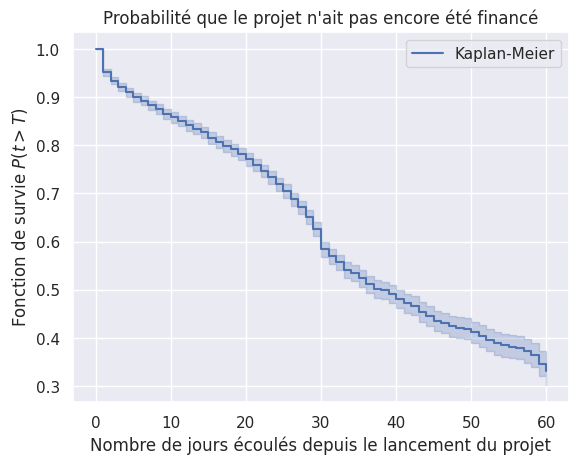

In [ ]:
plot_survival_estimation(
    survival_models["Kaplan-Meier"], event_times, event_observed, "Kaplan-Meier"
)

### Kaplan-Meier (avec et sans censure)

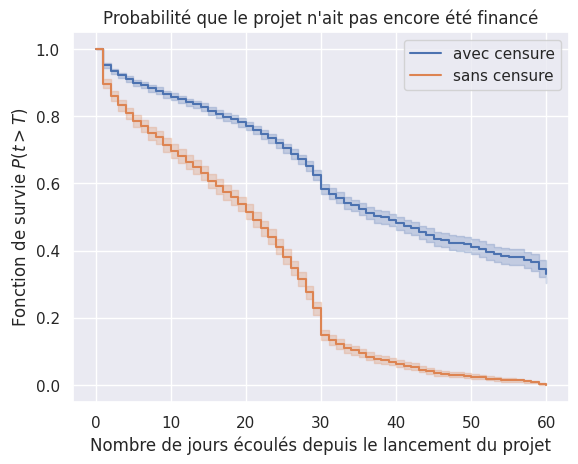

In [ ]:
plot_survival_estimation(
    survival_models["Kaplan-Meier"], event_times, event_observed, "avec censure"
)
plot_survival_estimation(
    survival_models["Kaplan-Meier"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "sans censure",
)

### Co-variables

#### Vidéo de présentation

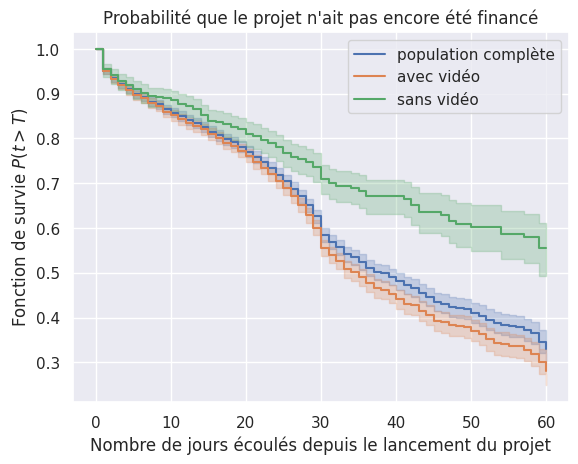

In [ ]:
plot_survival_estimation(
    survival_models["Kaplan-Meier"], event_times, event_observed, "population complète"
)
plot_survival_estimation(
    survival_models["Kaplan-Meier"], t_video, o_video, "avec vidéo"
)
plot_survival_estimation(
    survival_models["Kaplan-Meier"], t_no_video, o_no_video, "sans vidéo"
)

## Fonction de risque

In [ ]:
hazard_models = create_hazard_models()

### Nelson-Aalen

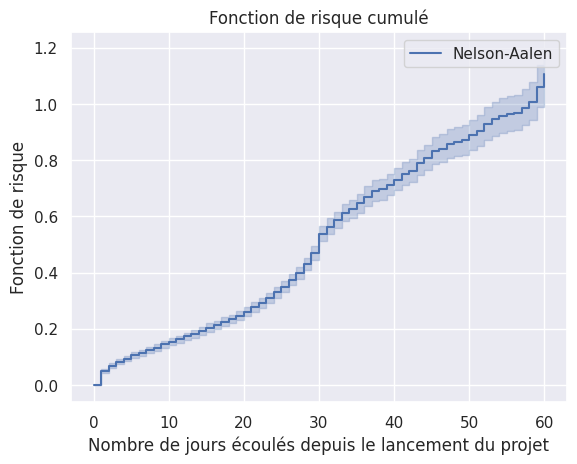

In [ ]:
plot_hazard_estimation(
    hazard_models["Nelson-Aalen"], event_times, event_observed, "Nelson-Aalen"
)

### Nelson-Aalen (avec et sans censure)

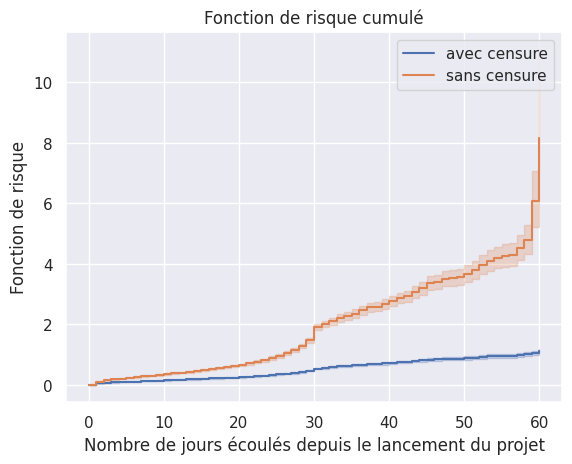

In [ ]:
plot_hazard_estimation(
    hazard_models["Nelson-Aalen"], event_times, event_observed, "avec censure"
)
plot_hazard_estimation(
    hazard_models["Nelson-Aalen"],
    event_times_no_censoring,
    event_observed_no_censoring,
    "sans censure",
)

### Co-variables

#### Vidéo de présentation

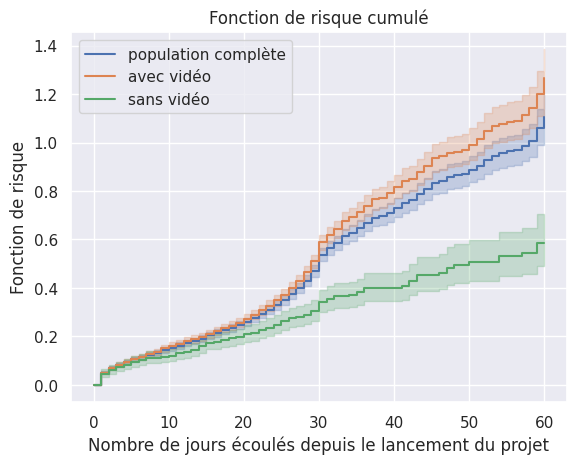

In [ ]:
plot_hazard_estimation(
    hazard_models["Nelson-Aalen"], event_times, event_observed, "population complète"
)
plot_hazard_estimation(hazard_models["Nelson-Aalen"], t_video, o_video, "avec vidéo")
plot_hazard_estimation(
    hazard_models["Nelson-Aalen"], t_no_video, o_no_video, "sans vidéo"
)